In [25]:
import numpy as np 
import pandas as pd
import sklearn
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Overview

The data collected includes some information about users, such as their firstname and their zipcode. However, the data table has a large number of missing values on the year of birth (yob) and the gender of the users. The goal of this project is to use data science methods to predict those missing values for the yob variable and the gender variable. 

The work is divided into 2 sections. The 1st one focuses on the prediction of the year of birth, which is treated as a regression problem. The 2nd section is about the prediction of the gender, which is a binary classification problem. 

# Predict the year of birth (yob) - Regression task

## 1) Data Preprocessing and Exploration

In [32]:
data = pd.read_csv("user_exo_2M.csv", delimiter=",")
data = data[0:100000]
dates = np.array([(2020-d) for d in data.yob])
data['years_ago'] = dates

most_common_zip = data['zipcode'].value_counts().idxmax()
data['zipcode'] = data['zipcode'].fillna(most_common_zip)
data['zipcode'] =  data['zipcode'].astype(str)

# we ignore the gender column because it has a lot of missing data 
# and does not contribute to improve the performance of our regression models

# categ_data = data[['domain', 'firstname', 'zipcode']]
# sparse_data = OneHotEncoder().fit_transform(categ_data)
X_training_data = pd.get_dummies(data[data['yob'] != -1][['domain', 'firstname', 'zipcode']], sparse=True)
X_training_data.shape

(60000, 6821)

In [33]:
training_yob_indices = data[data['yob'] != -1].index
# missing_yob_indices = data[data['yob'] == -1].index


# X_training_data = sparse.lil_matrix(sparse.csr_matrix(sparse_data)[training_yob_indices, :])
# X_missing_data = sparse.lil_matrix(sparse.csr_matrix(sparse_data)[missing_yob_indices, :])

# Y_training_data = data['years_ago'].loc[training_yob_indices]
Y_training_data = data[data['yob']!=-1].years_ago

y_test = data['years_ago'].loc[training_yob_indices]
print(Y_training_data.shape)


(60000,)


### Distribution of the yob variable

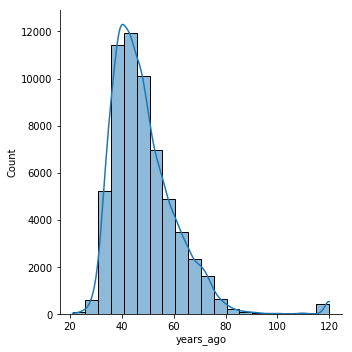

In [34]:
sns.displot(y_test, bins=20, kde=True)

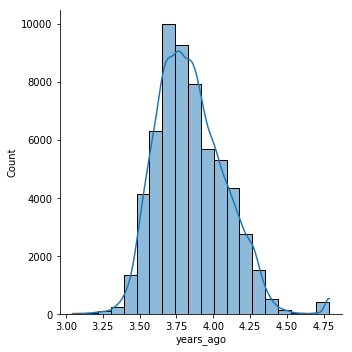

In [35]:
Y_training_data = np.log(Y_training_data)
sns.displot(Y_training_data, bins=20, kde=True)

In this project we use a log-transformation on the skewed target data to get a distribution that conforms with normality. 

As observed above, the distribution of the yob variable is skewed (to the right) in the 1st plot and closer to a normal distribution in the second plot, after applying the log transformation.

In [36]:
x_train, x_test, y_train, y_test = train_test_split(X_training_data, Y_training_data, test_size=0.2, random_state=42)

## 2) Statistical-Based Feature Selection : ANOVA test

We perform the statistical feature selection only on the training set, otherwise it will result in optimistically biased performance estimates. 

The feature selection should only be performed on the training set because, in the testing context, we don't have the target data and cannot calculate the correlation between x and y.

Once we find statistically significant columns in the training samples, we use them to reduce the dimensionality of both the training and testing data. 

In [37]:
from sklearn.feature_selection import f_classif # ANOVA test

def filter_data(x, y):
    p_vals = f_classif(x, y)[1]
    all_cols_indices = np.array([i for i in range(x.shape[1])])
    indep_cols_indices = np.array([idx for idx in range(len(p_vals)) if p_vals[idx]>0.05])
    essential_cols_indices = [i for i in all_cols_indices if i not in indep_cols_indices]

    return essential_cols_indices 

In [39]:
# The essential columns represent the statistically significant features.
essential_columns = filter_data(x_train,y_train)

x_train_filtered = sparse.lil_matrix(sparse.csr_matrix(x_train)[:,essential_columns])
x_test_filtered = sparse.lil_matrix(sparse.csr_matrix(x_test)[:,essential_columns])
# X_missing_filtered = sparse.lil_matrix(sparse.csr_matrix(X_missing_data)[:,essential_columns])

print("num of dimensions before feature selection: ", x_train.shape[1])
print("num of dimensions after feature selection: ", x_train_filtered.shape[1])

num of dimensions before feature selection:  6821
num of dimensions after feature selection:  1472


The ANOVA hyothesis test analyses the difference of variance between each predictor and the outcome variable.
For a given feature, when the F-value is large and p_value is small (less than 0.05 for a 95% confidence interval), we estimate that the feature is statistically significant.

Using the ANOVA test, we have selected all statistically significant features (with p<0.05) with respect the outcome variable y. Consequently, we have selected 3826 features out of 18040 and considerably reduced the dimensionality of the input.

Now let's see if the feature selection is useful and let's find out what type of regression model performs best.


## 3) Regression Model Selection

### Linear Regression

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score


def adjusted_r_squared(r2_sc, X):
    return (1-(1-r2_sc)*((X.shape[0]-1)/(X.shape[0]-(X[0].shape[1])-1)))


def train_linear_regression_model(x_train, y_train, x_test, y_test, reg_estimator):
        
    if (reg_estimator == "LinearRegression"):
        reg_mod = LinearRegression()
    
    if (reg_estimator == "Ridge"):
        reg_mod = Ridge(alpha=1)
        
         
    reg_mod.fit(x_train, y_train)
    train_r2_sc = reg_mod.score(x_train, y_train)
    train_adj_r2_sc = adjusted_r_squared(train_r2_sc, x_train)

    preds = reg_mod.predict(x_test)
    test_r2_sc = r2_score(y_test, preds)
    test_adj_r2_sc = adjusted_r_squared(test_r2_sc, x_test)
    
    return reg_mod, preds, train_adj_r2_sc, test_adj_r2_sc
    

In [ ]:
print("BEFORE FEATURE SELECTION:")
print("")
lin_reg_model1, lin_reg_preds, train_score, test_score = train_linear_regression_model(x_train, y_train, x_test, y_test, "LinearRegression")
print("Linear Regression, train_score:", train_score, ", test_score:", test_score)

ridge_reg_model1, ridge_reg_preds, train_score, test_score = train_linear_regression_model(x_train, y_train, x_test, y_test, "Ridge")
print("Ridge Regression, train_score:", train_score, ", test_score:", test_score)


BEFORE FEATURE SELECTION:



In [ ]:
print("AFTER FEATURE SELECTION:")
print("")

lin_reg_model2, lin_reg_preds, train_score, test_score = train_linear_regression_model(x_train_filtered, y_train, x_test_filtered, y_test, "LinearRegression")
print("Linear Regression, train_score:", train_score, ", test_score:", test_score)

ridge_reg_model2, ridge_reg_preds, train_score, test_score = train_linear_regression_model(x_train_filtered, y_train, x_test_filtered, y_test, "Ridge")
print("Ridge Regression, train_score:", train_score, ", test_score:", test_score)

The Ridge Regression model performs similarly to the Linear Regression model, despite its L2 regularization (which consists of adding the squared magnitude of coefficients as a penalty term in the loss function).

We observe that the ANOVA statistical feature selection is effective. It brings an improvement of 2% in the test score of the linear models. Additionally, the feature selection successfully tackles overfitting because it reduces the gap between the training and testing performance (from 5% to 1%).

### Visualise residuals against fitted values

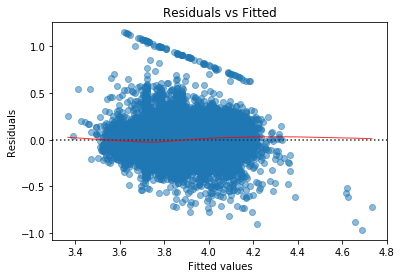

In [17]:
preds = lin_reg_preds

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(preds[0:50000], y_test[0:50000],
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

As we can see, the residuals are not randomly distributed around the regression line. Therefore there is some non-linear pattern which has not been learnt by the model. Additionally, the adjusted r2 score of the linear models is approximately 50%, which means that linear regression only captures 50% of the variance of the outcome variable.

This suggests that linear regression is not complex enough to provide informative insights on the yob variable in this dataset. We have to leverage more complex models that can capture the non-linearity within our data. In this regard, we can use neural networks, which apply non-linear transformations (e.g ReLU activations) to the output of each neuron before passing it to subsequent layers. 

### Non-Linear Regression with Neural Networks

In [18]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

model = tf.keras.Sequential([
    layers.InputLayer(input_shape=[x_train.shape[1]]),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)])

model.compile(optimizer="Adam", loss='mse',  metrics=['mae'])

# The callback will stop the training if there is no improvement in the validation loss for 3 consecutive epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,  restore_best_weights=True)

# set a large number of epochs to make sure that we use early stopping.
history = model.fit(x_train, np.array(y_train), epochs=40, validation_split=0.3, batch_size=256, callbacks=[callback])


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 33600 samples, validate on 14400 samples
Epoch 1/40
33600/33600 [==============================] - 6s 183us/sample - loss: 1.7648 - mean_absolute_error: 0.7639 - val_loss: 0.0576 - val_mean_absolute_error: 0.1755
Epoch 2/40
33600/33600 [==============================] - 6s 189us/sample - loss: 0.0449 - mean_absolute_error: 0.1566 - val_loss: 0.0557 - val_mean_absolute_error: 0.1729
Epoch 3/40
33600/33600 [==============================] - 6s 175us/sample - loss: 0.0381 - mean_absolute_error: 0.1460 - val_loss: 0.0527 - val_mean_absolute_error: 0.1689
Epoch 4/40
33600/33600 [==============================] - 6s 174us/sample - loss: 0.0353 - mean_absolute_error: 0.1400 - val_loss: 0.0547 - val_mean_absolute_error: 0.1713
Epoch 5/40
33600/33600 [==============================] - 6s 190us/sample - loss: 0.0321 - mean_absolute_error: 0.1336 - val_loss: 0.0530 - val_

We use early stopping to prevent the neural network from overfitting. The training is stopped as soon as the validation loss starts to increase (for 3 consecutive epochs). We also use "restore_best_weights=True" to restore the model weights from the epoch with the best validation loss.

In [19]:
preds = model.predict(x_test)
test_r_score = r2_score(y_test, preds)
test_adj_r_score = adjusted_r_squared(test_r_score, x_test)

print("Neural network regression performance:")
print("")
print("R-squared score on test set:", test_r_score)
print("Adjusted R-squared score on test set:", test_adj_r_score)

Neural network regression performance:

R-squared score on test set: 0.003305185364828156
Adjusted R-squared score on test set: -2.0664977130275455


In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

Against my expectations, the neural network did not outpeform the linear regression models despite the non-linear relu transformations.

Some other regression models (e.g Random Forests and SVR) could be trained and evaluated as well in the model selection phase. However, due to the large size of the dataset (2M x 18K), these models take a very long time to train on my computer. A potential solution is to use a cloud service which offers powerful GPUs to accelerate the whole machine learning pipeline, including data processing, training and inferencing.

## 4) Fill missing yob values in original data

In [25]:
Y_YOB_PREDS = ridge_reg_model2.predict(X_missing_filtered)
Y_YOB_PREDS = [int(round(2020-np.exp(pred))) for pred in Y_YOB_PREDS]

all_data = data.copy()
all_data.loc[missing_yob_indices, 'yob'] = Y_YOB_PREDS

all_data.isnull().sum()

yob               0
domain            0
firstname         0
zipcode           0
gender       804954
years_ago         0
dtype: int64

# ----------------------------------------------------------------------------------------

# Predict the gender - Binary classification task

## 1) Data Preprocessing and Exploration

In [26]:
# we ignore the yob variable in our features because it did not bring any improvement to the performance.
features = all_data[['domain', 'firstname', 'zipcode']]

sparse_data2 = OneHotEncoder().fit_transform(features)
sparse_data2

<2000000x18040 sparse matrix of type '<class 'numpy.float64'>'
	with 6000000 stored elements in Compressed Sparse Row format>

In [27]:
training_gender_indices = all_data[all_data['gender'].notnull()].index
missing_gender_indices = all_data[all_data['gender'].isnull()].index

X_train_data = sparse.lil_matrix(sparse.csr_matrix(sparse_data2)[training_gender_indices, :])
X_miss_data = sparse.lil_matrix(sparse.csr_matrix(sparse_data2)[missing_gender_indices, :])

Y_train_data = all_data['gender'].loc[training_gender_indices]

### Distribution of the gender variable

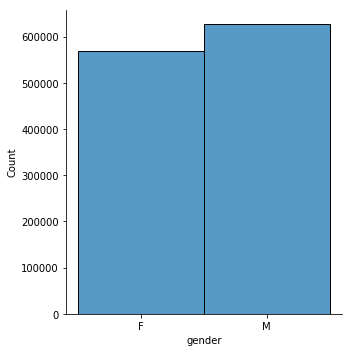

In [28]:
sns.displot(Y_train_data, bins=2)

The plot above shows the distribution of the gender data (outcome variable). The gender variable is well balanced between "Male" and "Female" and therefore our models predictive accuracy will not be biased by its distribution.

In [29]:
encoder = LabelEncoder()
encoder.fit(Y_train_data)
Y_train_data = encoder.transform(Y_train_data)

# encoder.inverse_transform([1]) 
# M is encoded as 1 and F is encoded as 0.

## 2) Statistical-Based Feature Selection : Chi-squared test

We perform the statistical feature selection only on the training set, otherwise it will result in optimistically biased performance estimates. 

The feature selection should only be performed on the training set because, in the testing context, we don't have the target data and cannot calculate the association between x and y.

Once we find statistically significant columns in the training samples, we use them to reduce the dimensionality of both the training and testing data. 

In [30]:
x_train, x_test, y_train, y_test = train_test_split(X_train_data, Y_train_data, test_size=0.2, random_state=42)

In [31]:
from sklearn.feature_selection import chi2

def filter_categ_data(x, y):
    
    p_values = (chi2(x, y)[1]).reshape(-1,1)

    all_cols_indices = np.array([i for i in range(x.shape[1])])
    indep_cols_indices = np.array([idx for idx in range(len(p_values)) if p_values[idx]>0.05])
    essential_cols_indices = [i for i in all_cols_indices if i not in indep_cols_indices]
    
    return essential_cols_indices

The Chi-squared test is a statistical test which measures the association between two categorical variables. In our case, we measure the pairwise association between each categorical feature (in the sparse matrix) to the gender variable.

The statistically significant features are those which produce a p-value that is less than 0.05 (according to a type 1 error rate of 5%).
Using the Chi-squared test, we have selected 7637 features out of 18040 and considerably reduced the dimensionality of the input.

Again, we will decide whether the feature selection is useful and figure out what type of classification model performs best.

In [34]:
essential_cols = filter_categ_data(x_train, y_train)

x_train_filt = sparse.lil_matrix(sparse.csr_matrix(x_train)[:,essential_cols])
x_test_filt = sparse.lil_matrix(sparse.csr_matrix(x_test)[:,essential_cols])
x_miss_filt = sparse.lil_matrix(sparse.csr_matrix(X_miss_data)[:,essential_cols])

print("num of dimensions before feature selection: ", x_train.shape[1])
print("num of dimensions after feature selection: ", x_train_filt.shape[1])

num of dimensions before feature selection:  18040
num of dimensions after feature selection:  7637


## 3) Classification Model Selection

### Linear classification model: Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def train_logistic_regression_model(x_train, y_train, x_test, y_test):
    
    log_reg = LogisticRegression(random_state=0).fit(x_train, y_train)
    train_preds = log_reg.predict(x_train)
    train_acc = log_reg.score(x_train, y_train)
    train_f1 = f1_score(y_train, train_preds, pos_label=1)

    test_preds = log_reg.predict(x_test)
    test_acc = accuracy_score(y_test, test_preds)
    test_f1 = f1_score(y_test, test_preds, pos_label=1)
    
    return log_reg, train_acc, train_f1, test_acc, test_f1


log_reg1, train_acc, train_f1, test_acc, test_f1 = train_logistic_regression_model(x_train, y_train, x_test, y_test)
print("Logistic regression results before feature selection: ")
print("train acc: ", train_acc, ", train f1: ", train_f1)
print("test acc: ", test_acc, ", test f1: ", test_f1)

print("-----------------------------------------------------------------------------------------")

log_reg2, train_acc, train_f1, test_acc, test_f1 = train_logistic_regression_model(x_train_filt, y_train, x_test_filt, y_test)
print("Logistic regression results after feature selection: ")
print("train acc: ", train_acc, ", train f1 score: ", train_f1)
print("test acc: ", test_acc, ", test f1 score: ", test_f1)

Logistic regression results before feature selection: 
train acc:  0.9486734809149446 , train f1:  0.9498002033772075
test acc:  0.9459646039914648 , test f1:  0.9472923834127112
-----------------------------------------------------------------------------------------
Logistic regression results after feature selection: 
train acc:  0.9412679020455297 , train f1 score:  0.9431810132500056
test acc:  0.9385883435839505 , test f1 score:  0.9408245377798922


This time, feature selection is not effective and leads to a slight drop in the classification performance (about -1%).

### Non-linear classification model: Neural Network

In [38]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses


model = tf.keras.Sequential([
    layers.InputLayer(input_shape=[x_train.shape[1]]),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')])

model.compile(optimizer="Adam", loss='binary_crossentropy',  metrics=['accuracy'])


# The callback will stop the training if there is no improvement in the validation loss for 2 consecutive epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# set a large number of epochs to make sure that we use early stopping.
history = model.fit(x_train, y_train, epochs=1000, batch_size=256, validation_split=0.2, callbacks=[callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 764828 samples, validate on 191208 samples
Epoch 1/1000
764828/764828 [==============================] - 271s 355us/sample - loss: 0.2090 - acc: 0.9345 - val_loss: 0.1922 - val_acc: 0.9439
Epoch 2/1000
764828/764828 [==============================] - 256s 335us/sample - loss: 0.1827 - acc: 0.9476 - val_loss: 0.1904 - val_acc: 0.9449
Epoch 3/1000
764828/764828 [==============================] - 285s 372us/sample - loss: 0.1711 - acc: 0.9505 - val_loss: 0.1933 - val_acc: 0.9448
Epoch 4/1000
764828/764828 [==============================] - 286s 374us/sample - loss: 0.1519 - acc: 0.9534 - val_loss: 0.2053 - val_acc: 0.9441


We use early stopping to prevent the neural network from overfitting. The training is halted as soon as the validation loss starts to increase (for 2 consecutive epochs). We also use "restore_best_weights=True" to restore the model weights from the epoch with the best validation loss.

In [40]:
preds = model.predict(x_test)
preds = [0 if p<0.5 else 1 for p in preds]
test_acc = accuracy_score(y_test, preds)
test_f1 = f1_score(y_test, preds, pos_label=1)
print("Neural network classification performance:")
print("testing acc: ", test_acc, ", testing f1 score: ", test_f1)

Neural network classification performance:
testing acc:  0.9451696581732982 , testing f1 score:  0.9463378280435522


We observe that the neural network achieves a similar performance to the logistic regression model.

Unlike the regression task (on yob), the gender classification task does not require complex models to capture essential patterns within the data. Indeed the logistic model achieves a very high accuracy and F1 score of roughly 95%.

Therefore, we can use the logistic regression model for gender classification.

## 4) Fill missing gender values in original data

In [50]:
Y_GENDER_PREDS = log_reg1.predict(X_miss_data)
Y_GENDER_PREDS = ["M" if e==1 else "F" for e in Y_GENDER_PREDS]
all_data.loc[missing_gender_indices, 'gender'] = Y_GENDER_PREDS
all_data = all_data.drop('years_ago', axis=1)
all_data

,yob,domain,firstname,zipcode,gender
0,1985,@wanadoo.fr,b08253b305fb5ec,94450.0,F
1,1961,@sfr.fr,7ff135854376850,78580.0,M
2,1977,@free.fr,172522ec1028ab7,62640.0,M
3,1975,@hotmail.com,d3ca5dde60f88db,94100.0,M
4,1985,@gmail.com,bdaae16837dd576,78100.0,M
...,...,...,...,...,...
1999995,1994,@gmail.com,09f96867a8dc816,62400.0,F
1999996,1997,@gmail.com,823fec7a2632ea7,7200.0,M
1999997,1998,@gmail.com,029f0f59eba0903,21000.0,F
1999998,1984,@hotmail.com,deb97a759ee7b8b,26240.0,M


In [51]:
all_data.isnull().sum()

yob          0
domain       0
firstname    0
zipcode      0
gender       0
dtype: int64

In [52]:
all_data.to_csv("user_completed.csv", index=True)

# Conclusion

Overall, the proposed pipeline achieves a high accuracy of roughly 95% on gender classification and a relatively small adjusted r2 score of 50% on yob regression. 

The statistical feature selection brought a performance improvement of 2% in the regression task and no improvement in the classification task. However, it is generally a good practice which leads to faster training and more reliable predictor estimates, since it tackles variance inflation.

A little more investigation is needed to understand why the neural network does not outperform the linear regression models on yob prediction, despite the inherent non-linearity of the data. An appropriate non-linear model should certainly learn some more complex patterns and capture more than 50% of the target variance.